# Transfer Learning Template

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

    
import os, json, sys, time, random
import numpy as np
import torch
from torch.optim import Adam
from  easydict import EasyDict
import matplotlib.pyplot as plt

from steves_models.steves_ptn import Steves_Prototypical_Network

from steves_utils.lazy_iterable_wrapper import Lazy_Iterable_Wrapper
from steves_utils.iterable_aggregator import Iterable_Aggregator
from steves_utils.ptn_train_eval_test_jig import  PTN_Train_Eval_Test_Jig
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.torch_utils import get_dataset_metrics, ptn_confusion_by_domain_over_dataloader
from steves_utils.utils_v2 import (per_domain_accuracy_from_confusion, get_datasets_base_path)
from steves_utils.PTN.utils import independent_accuracy_assesment

from torch.utils.data import DataLoader

from steves_utils.stratified_dataset.episodic_accessor import Episodic_Accessor_Factory

from steves_utils.ptn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.transforms import get_chained_transform

# Allowed Parameters
These are allowed parameters, not defaults
Each of these values need to be present in the injected parameters (the notebook will raise an exception if they are not present)

Papermill uses the cell tag "parameters" to inject the real parameters below this cell.
Enable tags to see what I mean

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "seed",
    "dataset_seed",
    "n_shot",
    "n_query",
    "n_way",
    "train_k_factor",
    "val_k_factor",
    "test_k_factor",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "x_net",
    "datasets",
    "torch_default_dtype",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "x_shape",
}

In [3]:
from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)

from steves_utils.ORACLE.utils_v2 import (
    ALL_DISTANCES_FEET_NARROWED,
    ALL_RUNS,
    ALL_SERIAL_NUMBERS,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "STANDALONE PTN"
standalone_parameters["lr"] = 0.001
standalone_parameters["device"] = "cuda"

standalone_parameters["seed"] = 1337
standalone_parameters["dataset_seed"] = 1337

standalone_parameters["n_way"] = 8
standalone_parameters["n_shot"] = 3
standalone_parameters["n_query"]  = 2
standalone_parameters["train_k_factor"] = 1
standalone_parameters["val_k_factor"] = 2
standalone_parameters["test_k_factor"] = 2


standalone_parameters["n_epoch"] = 50

standalone_parameters["patience"] = 10
standalone_parameters["criteria_for_best"] = "source_loss"

standalone_parameters["datasets"] = [
    {
        "labels": ALL_SERIAL_NUMBERS,
        "domains": ALL_DISTANCES_FEET_NARROWED,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "source",
        "x_transforms": ["unit_mag", "minus_two"],
        "episode_transforms": [],
        "domain_prefix": "ORACLE_"
    },
    {
        "labels": ALL_NODES,
        "domains": ALL_DAYS,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "target",
        "x_transforms": ["unit_power", "times_zero"],
        "episode_transforms": [],
        "domain_prefix": "CORES_"
    }   
]

standalone_parameters["torch_default_dtype"] = "torch.float32" 



standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
]

# Parameters relevant to results
# These parameters will basically never need to change
standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"






In [4]:
# Parameters
parameters = {
    "experiment_name": "tl_1v2:oracle.run1.framed-oracle.run2.framed",
    "device": "cuda",
    "lr": 0.0001,
    "n_shot": 3,
    "n_query": 2,
    "train_k_factor": 3,
    "val_k_factor": 2,
    "test_k_factor": 2,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "n_way": 16,
    "datasets": [
        {
            "labels": [
                "3123D52",
                "3123D65",
                "3123D79",
                "3123D80",
                "3123D54",
                "3123D70",
                "3123D7B",
                "3123D89",
                "3123D58",
                "3123D76",
                "3123D7D",
                "3123EFE",
                "3123D64",
                "3123D78",
                "3123D7E",
                "3124E4A",
            ],
            "domains": [32, 38, 8, 44, 14, 50, 20, 26],
            "num_examples_per_domain_per_label": 2000,
            "pickle_path": "/root/csc500-main/datasets/oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl",
            "source_or_target_dataset": "target",
            "x_transforms": ["unit_power"],
            "episode_transforms": [],
            "domain_prefix": "ORACLE.run1_",
        },
        {
            "labels": [
                "3123D52",
                "3123D65",
                "3123D79",
                "3123D80",
                "3123D54",
                "3123D70",
                "3123D7B",
                "3123D89",
                "3123D58",
                "3123D76",
                "3123D7D",
                "3123EFE",
                "3123D64",
                "3123D78",
                "3123D7E",
                "3124E4A",
            ],
            "domains": [32, 38, 8, 44, 14, 50, 20, 26],
            "num_examples_per_domain_per_label": 2000,
            "pickle_path": "/root/csc500-main/datasets/oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl",
            "source_or_target_dataset": "source",
            "x_transforms": ["unit_power"],
            "episode_transforms": [],
            "domain_prefix": "ORACLE.run2_",
        },
    ],
    "dataset_seed": 1337,
    "seed": 1337,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

if "x_shape" not in p:
    p.x_shape = [2,256] # Default to this if we dont supply x_shape


supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")

In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
###########################################
# The stratified datasets honor this
###########################################
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
p.domains_source = []
p.domains_target = []


train_original_source = []
val_original_source   = []
test_original_source  = []

train_original_target = []
val_original_target   = []
test_original_target  = []

In [11]:
# global_x_transform_func = lambda x: normalize(x.to(torch.get_default_dtype()), "unit_power") # unit_power, unit_mag
# global_x_transform_func = lambda x: normalize(x, "unit_power") # unit_power, unit_mag

In [12]:
def add_dataset(
    labels,
    domains,
    pickle_path,
    x_transforms,
    episode_transforms,
    domain_prefix,
    num_examples_per_domain_per_label,
    source_or_target_dataset:str,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
):
   
    if x_transforms == []: x_transform = None
    else: x_transform = get_chained_transform(x_transforms)
    
    if episode_transforms == []: episode_transform = None
    else: raise Exception("episode_transforms not implemented")
    
    episode_transform = lambda tup, _prefix=domain_prefix: (_prefix + str(tup[0]), tup[1])


    eaf = Episodic_Accessor_Factory(
        labels=labels,
        domains=domains,
        num_examples_per_domain_per_label=num_examples_per_domain_per_label,
        iterator_seed=iterator_seed,
        dataset_seed=dataset_seed,
        n_shot=n_shot,
        n_way=n_way,
        n_query=n_query,
        train_val_test_k_factors=train_val_test_k_factors,
        pickle_path=pickle_path,
        x_transform_func=x_transform,
    )

    train, val, test = eaf.get_train(), eaf.get_val(), eaf.get_test()
    train = Lazy_Iterable_Wrapper(train, episode_transform)
    val = Lazy_Iterable_Wrapper(val, episode_transform)
    test = Lazy_Iterable_Wrapper(test, episode_transform)

    if source_or_target_dataset=="source":
        train_original_source.append(train)
        val_original_source.append(val)
        test_original_source.append(test)

        p.domains_source.extend(
            [domain_prefix + str(u) for u in domains]
        )
    elif source_or_target_dataset=="target":
        train_original_target.append(train)
        val_original_target.append(val)
        test_original_target.append(test)
        p.domains_target.extend(
            [domain_prefix + str(u) for u in domains]
        )
    else:
        raise Exception(f"invalid source_or_target_dataset: {source_or_target_dataset}")
    

In [13]:
for ds in p.datasets:
    add_dataset(**ds)

In [14]:
# from steves_utils.CORES.utils import (
#     ALL_NODES,
#     ALL_NODES_MINIMUM_1000_EXAMPLES,
#     ALL_DAYS
# )

# add_dataset(
#     labels=ALL_NODES,
#     domains = ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"cores_{u}"
# )

In [15]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle1_{u}"
# )


In [16]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62,56}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle2_{u}"
# )

In [17]:
# add_dataset(
#     labels=list(range(19)),
#     domains = [0,1,2],
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "metehan.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"met_{u}"
# )

In [18]:
# # from steves_utils.wisig.utils import (
# #     ALL_NODES_MINIMUM_100_EXAMPLES,
# #     ALL_NODES_MINIMUM_500_EXAMPLES,
# #     ALL_NODES_MINIMUM_1000_EXAMPLES,
# #     ALL_DAYS
# # )

# import steves_utils.wisig.utils as wisig


# add_dataset(
#     labels=wisig.ALL_NODES_MINIMUM_100_EXAMPLES,
#     domains = wisig.ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "wisig.node3-19.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"wisig_{u}"
# )

In [19]:
###################################
# Build the dataset
###################################
train_original_source = Iterable_Aggregator(train_original_source, p.seed)
val_original_source = Iterable_Aggregator(val_original_source, p.seed)
test_original_source = Iterable_Aggregator(test_original_source, p.seed)


train_original_target = Iterable_Aggregator(train_original_target, p.seed)
val_original_target = Iterable_Aggregator(val_original_target, p.seed)
test_original_target = Iterable_Aggregator(test_original_target, p.seed)

# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Iterable_Wrapper. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[1] # Original is (<domain>, <episode>) so we strip down to episode only

train_processed_source = Lazy_Iterable_Wrapper(train_original_source, transform_lambda)
val_processed_source   = Lazy_Iterable_Wrapper(val_original_source, transform_lambda)
test_processed_source  = Lazy_Iterable_Wrapper(test_original_source, transform_lambda)

train_processed_target = Lazy_Iterable_Wrapper(train_original_target, transform_lambda)
val_processed_target   = Lazy_Iterable_Wrapper(val_original_target, transform_lambda)
test_processed_target  = Lazy_Iterable_Wrapper(test_original_target, transform_lambda)

datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [20]:
from steves_utils.transforms import get_average_magnitude, get_average_power

print(set([u for u,_ in val_original_source]))
print(set([u for u,_ in val_original_target]))

s_x, s_y, q_x, q_y, _ = next(iter(train_processed_source))
print(s_x)

# for ds in [
#     train_processed_source,
#     val_processed_source,
#     test_processed_source,
#     train_processed_target,
#     val_processed_target,
#     test_processed_target
# ]:
#     for s_x, s_y, q_x, q_y, _ in ds:
#         for X in (s_x, q_x):
#             for x in X:
#                 assert np.isclose(get_average_magnitude(x.numpy()), 1.0)
#                 assert np.isclose(get_average_power(x.numpy()), 1.0)
                

{'ORACLE.run2_50', 'ORACLE.run2_20', 'ORACLE.run2_44', 'ORACLE.run2_8', 'ORACLE.run2_32', 'ORACLE.run2_38', 'ORACLE.run2_14', 'ORACLE.run2_26'}


{'ORACLE.run1_20', 'ORACLE.run1_8', 'ORACLE.run1_50', 'ORACLE.run1_14', 'ORACLE.run1_32', 'ORACLE.run1_26', 'ORACLE.run1_44', 'ORACLE.run1_38'}


tensor([[[ 0.8991,  0.0908, -1.0172,  ...,  0.2816,  1.3714,  0.1453],
         [ 0.3815,  1.1444, -0.4632,  ..., -0.9264, -0.0727, -1.0263]],

        [[ 0.9651,  0.3642, -1.1107,  ..., -0.2458,  1.2018, -0.3551],
         [ 0.0546,  0.9833, -0.1001,  ..., -1.1927, -0.6555, -0.9924]],

        [[ 0.2039,  1.0937, -0.5654,  ..., -1.2235,  0.7322,  0.2225],
         [-0.5561,  0.3986,  0.7044,  ..., -0.5191, -1.0752, -0.8991]],

        ...,

        [[ 0.0504, -1.2349,  0.2331,  ...,  1.1845, -0.3213,  0.0819],
         [ 0.6490, -0.0693, -0.7876,  ...,  0.0000,  1.2665,  0.9892]],

        [[ 0.7104, -0.5484, -0.8973,  ...,  1.0718,  0.8849, -0.3677],
         [ 0.9222,  0.4237, -0.9721,  ..., -0.5297, -0.3739, -1.2400]],

        [[ 0.3635, -0.6768, -0.4199,  ...,  1.0653,  1.1029,  0.7019],
         [ 1.0402,  0.4951, -1.2408,  ..., -0.3133,  0.6768, -1.0402]]])


In [21]:
###################################
# Build the model
###################################
# easfsl only wants a tuple for the shape
model = Steves_Prototypical_Network(x_net, device=p.device, x_shape=tuple(p.x_shape))
optimizer = Adam(params=model.parameters(), lr=p.lr)

(2, 256)


In [22]:
###################################
# train
###################################
jig = PTN_Train_Eval_Test_Jig(model, p.BEST_MODEL_PATH, p.device)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    patience=p.patience,
    optimizer=optimizer,
    criteria_for_best=p.criteria_for_best,
)

epoch: 1, [batch: 1 / 6720], examples_per_second: 33.6595, train_label_loss: 2.7355, 


epoch: 1, [batch: 672 / 6720], examples_per_second: 2560.5716, train_label_loss: 0.9748, 


epoch: 1, [batch: 1344 / 6720], examples_per_second: 2580.0438, train_label_loss: 0.5424, 


epoch: 1, [batch: 2016 / 6720], examples_per_second: 2574.9773, train_label_loss: 0.4687, 


epoch: 1, [batch: 2688 / 6720], examples_per_second: 2928.0423, train_label_loss: 0.8362, 


epoch: 1, [batch: 3360 / 6720], examples_per_second: 2948.9873, train_label_loss: 0.7832, 


epoch: 1, [batch: 4032 / 6720], examples_per_second: 2918.3485, train_label_loss: 0.5755, 


epoch: 1, [batch: 4704 / 6720], examples_per_second: 2946.3025, train_label_loss: 0.3927, 


epoch: 1, [batch: 5376 / 6720], examples_per_second: 2937.9741, train_label_loss: 0.3533, 


epoch: 1, [batch: 6048 / 6720], examples_per_second: 3058.5628, train_label_loss: 0.5949, 


epoch: 1, source_val_acc_label: 0.6667, target_val_acc_label: 0.6627, source_val_label_loss: 94.2920, target_val_label_loss: 110.6359, 


New best


epoch: 2, [batch: 1 / 6720], examples_per_second: 3.1562, train_label_loss: 258.0537, 


epoch: 2, [batch: 672 / 6720], examples_per_second: 2377.9894, train_label_loss: 0.5423, 


epoch: 2, [batch: 1344 / 6720], examples_per_second: 2286.6228, train_label_loss: 0.4591, 


epoch: 2, [batch: 2016 / 6720], examples_per_second: 2316.9194, train_label_loss: 0.4375, 


epoch: 2, [batch: 2688 / 6720], examples_per_second: 2304.7844, train_label_loss: 0.5198, 


epoch: 2, [batch: 3360 / 6720], examples_per_second: 2298.7473, train_label_loss: 0.7354, 


epoch: 2, [batch: 4032 / 6720], examples_per_second: 2293.6261, train_label_loss: 0.9421, 


epoch: 2, [batch: 4704 / 6720], examples_per_second: 2293.0507, train_label_loss: 0.5057, 


epoch: 2, [batch: 5376 / 6720], examples_per_second: 2304.5739, train_label_loss: 1.1968, 


epoch: 2, [batch: 6048 / 6720], examples_per_second: 2552.9233, train_label_loss: 0.4919, 


epoch: 2, source_val_acc_label: 0.8258, target_val_acc_label: 0.8221, source_val_label_loss: 0.5049, target_val_label_loss: 0.4951, 


New best


epoch: 3, [batch: 1 / 6720], examples_per_second: 2.3841, train_label_loss: 0.6475, 


epoch: 3, [batch: 672 / 6720], examples_per_second: 2388.7596, train_label_loss: 0.3903, 


epoch: 3, [batch: 1344 / 6720], examples_per_second: 2346.1520, train_label_loss: 0.3082, 


epoch: 3, [batch: 2016 / 6720], examples_per_second: 2322.4548, train_label_loss: 0.4064, 


epoch: 3, [batch: 2688 / 6720], examples_per_second: 2312.2672, train_label_loss: 0.4174, 


epoch: 3, [batch: 3360 / 6720], examples_per_second: 2311.5435, train_label_loss: 0.7595, 


epoch: 3, [batch: 4032 / 6720], examples_per_second: 2309.7094, train_label_loss: 0.6812, 


epoch: 3, [batch: 4704 / 6720], examples_per_second: 2290.2514, train_label_loss: 0.2476, 


epoch: 3, [batch: 5376 / 6720], examples_per_second: 2438.8939, train_label_loss: 0.2981, 


epoch: 3, [batch: 6048 / 6720], examples_per_second: 2599.1572, train_label_loss: 0.1376, 


epoch: 3, source_val_acc_label: 0.8344, target_val_acc_label: 0.8339, source_val_label_loss: 0.5223, target_val_label_loss: 0.4633, 


New best


epoch: 4, [batch: 1 / 6720], examples_per_second: 2.3007, train_label_loss: 0.1285, 


epoch: 4, [batch: 672 / 6720], examples_per_second: 2376.1442, train_label_loss: 0.1779, 


epoch: 4, [batch: 1344 / 6720], examples_per_second: 2308.5209, train_label_loss: 0.7825, 


epoch: 4, [batch: 2016 / 6720], examples_per_second: 2326.1305, train_label_loss: 0.5437, 


epoch: 4, [batch: 2688 / 6720], examples_per_second: 2311.2863, train_label_loss: 0.2668, 


epoch: 4, [batch: 3360 / 6720], examples_per_second: 2310.0167, train_label_loss: 0.1799, 


epoch: 4, [batch: 4032 / 6720], examples_per_second: 2493.2607, train_label_loss: 0.6445, 


epoch: 4, [batch: 4704 / 6720], examples_per_second: 2679.7703, train_label_loss: 0.4256, 


epoch: 4, [batch: 5376 / 6720], examples_per_second: 2937.2267, train_label_loss: 0.5066, 


epoch: 4, [batch: 6048 / 6720], examples_per_second: 2944.5526, train_label_loss: 0.4988, 


epoch: 4, source_val_acc_label: 0.8562, target_val_acc_label: 0.8460, source_val_label_loss: 0.4047, target_val_label_loss: 0.4269, 


New best


epoch: 5, [batch: 1 / 6720], examples_per_second: 2.5513, train_label_loss: 0.2524, 


epoch: 5, [batch: 672 / 6720], examples_per_second: 2997.9447, train_label_loss: 0.1060, 


epoch: 5, [batch: 1344 / 6720], examples_per_second: 2378.1968, train_label_loss: 0.5150, 


epoch: 5, [batch: 2016 / 6720], examples_per_second: 2300.0043, train_label_loss: 0.4325, 


epoch: 5, [batch: 2688 / 6720], examples_per_second: 2304.5365, train_label_loss: 0.2642, 


epoch: 5, [batch: 3360 / 6720], examples_per_second: 2328.1447, train_label_loss: 0.2535, 


epoch: 5, [batch: 4032 / 6720], examples_per_second: 2401.5060, train_label_loss: 0.5079, 


epoch: 5, [batch: 4704 / 6720], examples_per_second: 2581.2785, train_label_loss: 0.1798, 


epoch: 5, [batch: 5376 / 6720], examples_per_second: 2624.0711, train_label_loss: 0.6455, 


epoch: 5, [batch: 6048 / 6720], examples_per_second: 2563.6697, train_label_loss: 0.2573, 


epoch: 5, source_val_acc_label: 0.8682, target_val_acc_label: 0.8624, source_val_label_loss: 0.3695, target_val_label_loss: 0.3841, 


New best


epoch: 6, [batch: 1 / 6720], examples_per_second: 2.1924, train_label_loss: 0.2936, 


epoch: 6, [batch: 672 / 6720], examples_per_second: 2326.9451, train_label_loss: 0.5029, 


epoch: 6, [batch: 1344 / 6720], examples_per_second: 2305.5808, train_label_loss: 0.3348, 


epoch: 6, [batch: 2016 / 6720], examples_per_second: 2329.8926, train_label_loss: 0.2516, 


epoch: 6, [batch: 2688 / 6720], examples_per_second: 2289.3324, train_label_loss: 0.6354, 


epoch: 6, [batch: 3360 / 6720], examples_per_second: 2339.9499, train_label_loss: 0.4884, 


epoch: 6, [batch: 4032 / 6720], examples_per_second: 2577.7223, train_label_loss: 0.3830, 


epoch: 6, [batch: 4704 / 6720], examples_per_second: 2612.3872, train_label_loss: 0.2409, 


epoch: 6, [batch: 5376 / 6720], examples_per_second: 2620.4046, train_label_loss: 0.1130, 


epoch: 6, [batch: 6048 / 6720], examples_per_second: 2309.1240, train_label_loss: 0.1442, 


epoch: 6, source_val_acc_label: 0.8639, target_val_acc_label: 0.8539, source_val_label_loss: 0.3897, target_val_label_loss: 0.4123, 


epoch: 7, [batch: 1 / 6720], examples_per_second: 2.2048, train_label_loss: 0.2782, 


epoch: 7, [batch: 672 / 6720], examples_per_second: 2363.4090, train_label_loss: 0.5662, 


epoch: 7, [batch: 1344 / 6720], examples_per_second: 2314.0405, train_label_loss: 0.2059, 


epoch: 7, [batch: 2016 / 6720], examples_per_second: 2323.2083, train_label_loss: 0.1929, 


epoch: 7, [batch: 2688 / 6720], examples_per_second: 2281.2955, train_label_loss: 0.2655, 


epoch: 7, [batch: 3360 / 6720], examples_per_second: 2468.9286, train_label_loss: 0.4581, 


epoch: 7, [batch: 4032 / 6720], examples_per_second: 2603.0169, train_label_loss: 0.1577, 


epoch: 7, [batch: 4704 / 6720], examples_per_second: 2627.0653, train_label_loss: 0.3164, 


epoch: 7, [batch: 5376 / 6720], examples_per_second: 2581.1739, train_label_loss: 0.1350, 


epoch: 7, [batch: 6048 / 6720], examples_per_second: 2529.1755, train_label_loss: 0.1544, 


epoch: 7, source_val_acc_label: 0.8578, target_val_acc_label: 0.8499, source_val_label_loss: 0.3976, target_val_label_loss: 0.4307, 


epoch: 8, [batch: 1 / 6720], examples_per_second: 2.5341, train_label_loss: 0.6123, 


epoch: 8, [batch: 672 / 6720], examples_per_second: 2612.4933, train_label_loss: 0.5636, 


epoch: 8, [batch: 1344 / 6720], examples_per_second: 2522.3235, train_label_loss: 0.4122, 


epoch: 8, [batch: 2016 / 6720], examples_per_second: 2588.7066, train_label_loss: 0.2590, 


epoch: 8, [batch: 2688 / 6720], examples_per_second: 2969.6402, train_label_loss: 0.0275, 


epoch: 8, [batch: 3360 / 6720], examples_per_second: 2948.9125, train_label_loss: 0.3417, 


epoch: 8, [batch: 4032 / 6720], examples_per_second: 2976.9961, train_label_loss: 0.5675, 


epoch: 8, [batch: 4704 / 6720], examples_per_second: 2977.0118, train_label_loss: 0.3218, 


epoch: 8, [batch: 5376 / 6720], examples_per_second: 2950.7663, train_label_loss: 0.0601, 


epoch: 8, [batch: 6048 / 6720], examples_per_second: 2995.7608, train_label_loss: 0.1274, 


epoch: 8, source_val_acc_label: 0.8887, target_val_acc_label: 0.8761, source_val_label_loss: 0.3068, target_val_label_loss: 0.3479, 


New best


epoch: 9, [batch: 1 / 6720], examples_per_second: 2.9077, train_label_loss: 0.2041, 


epoch: 9, [batch: 672 / 6720], examples_per_second: 2542.9621, train_label_loss: 0.1565, 


epoch: 9, [batch: 1344 / 6720], examples_per_second: 2588.3024, train_label_loss: 0.2997, 


epoch: 9, [batch: 2016 / 6720], examples_per_second: 2602.2184, train_label_loss: 0.1162, 


epoch: 9, [batch: 2688 / 6720], examples_per_second: 2546.8655, train_label_loss: 0.0504, 


epoch: 9, [batch: 3360 / 6720], examples_per_second: 2565.6600, train_label_loss: 0.3221, 


epoch: 9, [batch: 4032 / 6720], examples_per_second: 2530.7019, train_label_loss: 0.6311, 


epoch: 9, [batch: 4704 / 6720], examples_per_second: 2670.6177, train_label_loss: 0.0253, 


epoch: 9, [batch: 5376 / 6720], examples_per_second: 2729.3114, train_label_loss: 0.0440, 


epoch: 9, [batch: 6048 / 6720], examples_per_second: 2988.3229, train_label_loss: 0.1306, 


epoch: 9, source_val_acc_label: 0.8891, target_val_acc_label: 0.8772, source_val_label_loss: 0.3440, target_val_label_loss: 0.3504, 


New best


epoch: 10, [batch: 1 / 6720], examples_per_second: 2.4615, train_label_loss: 0.4813, 


epoch: 10, [batch: 672 / 6720], examples_per_second: 2293.8402, train_label_loss: 0.0511, 


epoch: 10, [batch: 1344 / 6720], examples_per_second: 2319.3138, train_label_loss: 0.1735, 


epoch: 10, [batch: 2016 / 6720], examples_per_second: 2316.3011, train_label_loss: 0.2960, 


epoch: 10, [batch: 2688 / 6720], examples_per_second: 2322.7903, train_label_loss: 0.2265, 


epoch: 10, [batch: 3360 / 6720], examples_per_second: 2311.9882, train_label_loss: 0.1854, 


epoch: 10, [batch: 4032 / 6720], examples_per_second: 2321.5553, train_label_loss: 0.2443, 


epoch: 10, [batch: 4704 / 6720], examples_per_second: 2298.0188, train_label_loss: 0.3598, 


epoch: 10, [batch: 5376 / 6720], examples_per_second: 2294.6010, train_label_loss: 0.3139, 


epoch: 10, [batch: 6048 / 6720], examples_per_second: 2545.4141, train_label_loss: 0.0960, 


epoch: 10, source_val_acc_label: 0.8844, target_val_acc_label: 0.8673, source_val_label_loss: 0.3171, target_val_label_loss: 0.3727, 


epoch: 11, [batch: 1 / 6720], examples_per_second: 2.4504, train_label_loss: 0.1872, 


epoch: 11, [batch: 672 / 6720], examples_per_second: 2658.1297, train_label_loss: 0.1383, 


epoch: 11, [batch: 1344 / 6720], examples_per_second: 2587.4558, train_label_loss: 0.1511, 


epoch: 11, [batch: 2016 / 6720], examples_per_second: 2611.1884, train_label_loss: 0.2163, 


epoch: 11, [batch: 2688 / 6720], examples_per_second: 2604.4517, train_label_loss: 0.2675, 


epoch: 11, [batch: 3360 / 6720], examples_per_second: 2544.5330, train_label_loss: 0.1712, 


epoch: 11, [batch: 4032 / 6720], examples_per_second: 2587.8722, train_label_loss: 0.0891, 


epoch: 11, [batch: 4704 / 6720], examples_per_second: 2607.2477, train_label_loss: 0.0231, 


epoch: 11, [batch: 5376 / 6720], examples_per_second: 2735.0490, train_label_loss: 0.0259, 


epoch: 11, [batch: 6048 / 6720], examples_per_second: 2968.0838, train_label_loss: 0.0880, 


epoch: 11, source_val_acc_label: 0.8941, target_val_acc_label: 0.8780, source_val_label_loss: 0.2952, target_val_label_loss: 0.3546, 


New best


epoch: 12, [batch: 1 / 6720], examples_per_second: 2.9646, train_label_loss: 0.3493, 


epoch: 12, [batch: 672 / 6720], examples_per_second: 2953.7704, train_label_loss: 0.2863, 


epoch: 12, [batch: 1344 / 6720], examples_per_second: 3102.0444, train_label_loss: 0.1449, 


epoch: 12, [batch: 2016 / 6720], examples_per_second: 2954.5709, train_label_loss: 0.3297, 


epoch: 12, [batch: 2688 / 6720], examples_per_second: 2956.7281, train_label_loss: 0.1170, 


epoch: 12, [batch: 3360 / 6720], examples_per_second: 3035.6578, train_label_loss: 0.0645, 


epoch: 12, [batch: 4032 / 6720], examples_per_second: 2950.0354, train_label_loss: 0.0226, 


epoch: 12, [batch: 4704 / 6720], examples_per_second: 2511.6813, train_label_loss: 0.2822, 


epoch: 12, [batch: 5376 / 6720], examples_per_second: 2536.3334, train_label_loss: 0.1321, 


epoch: 12, [batch: 6048 / 6720], examples_per_second: 2580.7211, train_label_loss: 0.0338, 


epoch: 12, source_val_acc_label: 0.8986, target_val_acc_label: 0.8777, source_val_label_loss: 0.2907, target_val_label_loss: 0.3571, 


epoch: 13, [batch: 1 / 6720], examples_per_second: 2.0754, train_label_loss: 0.1356, 


epoch: 13, [batch: 672 / 6720], examples_per_second: 2307.1316, train_label_loss: 0.2093, 


epoch: 13, [batch: 1344 / 6720], examples_per_second: 2315.6203, train_label_loss: 0.3011, 


epoch: 13, [batch: 2016 / 6720], examples_per_second: 2297.8442, train_label_loss: 0.0386, 


epoch: 13, [batch: 2688 / 6720], examples_per_second: 2384.8267, train_label_loss: 0.1326, 


epoch: 13, [batch: 3360 / 6720], examples_per_second: 2619.0066, train_label_loss: 0.0626, 


epoch: 13, [batch: 4032 / 6720], examples_per_second: 2571.6053, train_label_loss: 0.1617, 


epoch: 13, [batch: 4704 / 6720], examples_per_second: 2741.4494, train_label_loss: 0.0594, 


epoch: 13, [batch: 5376 / 6720], examples_per_second: 2561.6896, train_label_loss: 0.0517, 


epoch: 13, [batch: 6048 / 6720], examples_per_second: 2865.6998, train_label_loss: 0.3771, 


epoch: 13, source_val_acc_label: 0.8974, target_val_acc_label: 0.8834, source_val_label_loss: 0.2866, target_val_label_loss: 0.3334, 


New best


epoch: 14, [batch: 1 / 6720], examples_per_second: 2.2691, train_label_loss: 0.1107, 


epoch: 14, [batch: 672 / 6720], examples_per_second: 2659.7184, train_label_loss: 0.1139, 


epoch: 14, [batch: 1344 / 6720], examples_per_second: 2701.3344, train_label_loss: 0.1739, 


epoch: 14, [batch: 2016 / 6720], examples_per_second: 2644.6205, train_label_loss: 0.0637, 


epoch: 14, [batch: 2688 / 6720], examples_per_second: 3110.9866, train_label_loss: 0.1661, 


epoch: 14, [batch: 3360 / 6720], examples_per_second: 2837.0492, train_label_loss: 0.1924, 


epoch: 14, [batch: 4032 / 6720], examples_per_second: 2733.4403, train_label_loss: 0.2753, 


epoch: 14, [batch: 4704 / 6720], examples_per_second: 2824.6879, train_label_loss: 0.1486, 


epoch: 14, [batch: 5376 / 6720], examples_per_second: 2630.2211, train_label_loss: 0.0169, 


epoch: 14, [batch: 6048 / 6720], examples_per_second: 2395.6385, train_label_loss: 0.2986, 


epoch: 14, source_val_acc_label: 0.8927, target_val_acc_label: 0.8762, source_val_label_loss: 0.3036, target_val_label_loss: 0.3606, 


epoch: 15, [batch: 1 / 6720], examples_per_second: 2.0102, train_label_loss: 0.0824, 


epoch: 15, [batch: 672 / 6720], examples_per_second: 2292.5812, train_label_loss: 0.1582, 


epoch: 15, [batch: 1344 / 6720], examples_per_second: 2318.6478, train_label_loss: 0.1833, 


epoch: 15, [batch: 2016 / 6720], examples_per_second: 2317.1592, train_label_loss: 0.1191, 


epoch: 15, [batch: 2688 / 6720], examples_per_second: 2379.9644, train_label_loss: 0.1486, 


epoch: 15, [batch: 3360 / 6720], examples_per_second: 2664.9247, train_label_loss: 0.0519, 


epoch: 15, [batch: 4032 / 6720], examples_per_second: 2951.5231, train_label_loss: 0.3948, 


epoch: 15, [batch: 4704 / 6720], examples_per_second: 2774.5172, train_label_loss: 0.1332, 


epoch: 15, [batch: 5376 / 6720], examples_per_second: 2564.2164, train_label_loss: 0.0734, 


epoch: 15, [batch: 6048 / 6720], examples_per_second: 2574.5867, train_label_loss: 0.0965, 


epoch: 15, source_val_acc_label: 0.8976, target_val_acc_label: 0.8809, source_val_label_loss: 0.6896, target_val_label_loss: 0.3719, 


epoch: 16, [batch: 1 / 6720], examples_per_second: 2.2712, train_label_loss: 0.0892, 


epoch: 16, [batch: 672 / 6720], examples_per_second: 2527.1912, train_label_loss: 0.1398, 


epoch: 16, [batch: 1344 / 6720], examples_per_second: 2545.3219, train_label_loss: 0.0628, 


epoch: 16, [batch: 2016 / 6720], examples_per_second: 2553.4472, train_label_loss: 0.2075, 


epoch: 16, [batch: 2688 / 6720], examples_per_second: 3121.9771, train_label_loss: 0.2510, 


epoch: 16, [batch: 3360 / 6720], examples_per_second: 3508.9797, train_label_loss: 0.2262, 


epoch: 16, [batch: 4032 / 6720], examples_per_second: 3581.9906, train_label_loss: 0.2633, 


epoch: 16, [batch: 4704 / 6720], examples_per_second: 3038.0452, train_label_loss: 0.1224, 


epoch: 16, [batch: 5376 / 6720], examples_per_second: 3001.4063, train_label_loss: 0.3022, 


epoch: 16, [batch: 6048 / 6720], examples_per_second: 2952.3892, train_label_loss: 0.0419, 


epoch: 16, source_val_acc_label: 0.9014, target_val_acc_label: 0.8775, source_val_label_loss: 0.2855, target_val_label_loss: 0.3632, 


epoch: 17, [batch: 1 / 6720], examples_per_second: 2.2708, train_label_loss: 0.1370, 


epoch: 17, [batch: 672 / 6720], examples_per_second: 2300.1158, train_label_loss: 0.0764, 


epoch: 17, [batch: 1344 / 6720], examples_per_second: 2293.1647, train_label_loss: 0.0659, 


epoch: 17, [batch: 2016 / 6720], examples_per_second: 2288.7482, train_label_loss: 0.4298, 


epoch: 17, [batch: 2688 / 6720], examples_per_second: 2446.0782, train_label_loss: 0.0656, 


epoch: 17, [batch: 3360 / 6720], examples_per_second: 2624.6653, train_label_loss: 0.3406, 


epoch: 17, [batch: 4032 / 6720], examples_per_second: 2646.0742, train_label_loss: 0.1335, 


epoch: 17, [batch: 4704 / 6720], examples_per_second: 2387.5752, train_label_loss: 0.0583, 


epoch: 17, [batch: 5376 / 6720], examples_per_second: 2508.6474, train_label_loss: 0.1807, 


epoch: 17, [batch: 6048 / 6720], examples_per_second: 2594.4180, train_label_loss: 0.3367, 


epoch: 17, source_val_acc_label: 0.9041, target_val_acc_label: 0.8862, source_val_label_loss: 0.2828, target_val_label_loss: 0.3436, 


New best


epoch: 18, [batch: 1 / 6720], examples_per_second: 2.0950, train_label_loss: 0.2617, 


epoch: 18, [batch: 672 / 6720], examples_per_second: 2300.7044, train_label_loss: 0.0228, 


epoch: 18, [batch: 1344 / 6720], examples_per_second: 2327.7241, train_label_loss: 0.0997, 


epoch: 18, [batch: 2016 / 6720], examples_per_second: 2297.7758, train_label_loss: 0.2989, 


epoch: 18, [batch: 2688 / 6720], examples_per_second: 2633.2074, train_label_loss: 0.2431, 


epoch: 18, [batch: 3360 / 6720], examples_per_second: 2928.9967, train_label_loss: 0.1095, 


epoch: 18, [batch: 4032 / 6720], examples_per_second: 3016.2364, train_label_loss: 0.0823, 


epoch: 18, [batch: 4704 / 6720], examples_per_second: 2730.1511, train_label_loss: 0.1398, 


epoch: 18, [batch: 5376 / 6720], examples_per_second: 2958.7372, train_label_loss: 0.1084, 


epoch: 18, [batch: 6048 / 6720], examples_per_second: 3008.4365, train_label_loss: 0.2169, 


epoch: 18, source_val_acc_label: 0.9000, target_val_acc_label: 0.8783, source_val_label_loss: 0.2901, target_val_label_loss: 0.3585, 


epoch: 19, [batch: 1 / 6720], examples_per_second: 2.5642, train_label_loss: 0.2125, 


epoch: 19, [batch: 672 / 6720], examples_per_second: 2299.8262, train_label_loss: 0.0493, 


epoch: 19, [batch: 1344 / 6720], examples_per_second: 2308.3431, train_label_loss: 0.1661, 


epoch: 19, [batch: 2016 / 6720], examples_per_second: 2329.8955, train_label_loss: 0.1294, 


epoch: 19, [batch: 2688 / 6720], examples_per_second: 2461.0648, train_label_loss: 0.1361, 


epoch: 19, [batch: 3360 / 6720], examples_per_second: 2616.6938, train_label_loss: 0.0199, 


epoch: 19, [batch: 4032 / 6720], examples_per_second: 2637.9617, train_label_loss: 0.1142, 


epoch: 19, [batch: 4704 / 6720], examples_per_second: 2894.6057, train_label_loss: 0.2006, 


epoch: 19, [batch: 5376 / 6720], examples_per_second: 2953.2641, train_label_loss: 0.1402, 


epoch: 19, [batch: 6048 / 6720], examples_per_second: 3012.5337, train_label_loss: 0.2582, 


epoch: 19, source_val_acc_label: 0.9044, target_val_acc_label: 0.8819, source_val_label_loss: 0.2753, target_val_label_loss: 0.3492, 


epoch: 20, [batch: 1 / 6720], examples_per_second: 2.2939, train_label_loss: 0.2327, 


epoch: 20, [batch: 672 / 6720], examples_per_second: 2529.8697, train_label_loss: 0.1423, 


epoch: 20, [batch: 1344 / 6720], examples_per_second: 2524.0604, train_label_loss: 0.0318, 


epoch: 20, [batch: 2016 / 6720], examples_per_second: 2684.8159, train_label_loss: 0.3771, 


epoch: 20, [batch: 2688 / 6720], examples_per_second: 2958.4289, train_label_loss: 0.2030, 


epoch: 20, [batch: 3360 / 6720], examples_per_second: 2971.4152, train_label_loss: 0.1067, 


epoch: 20, [batch: 4032 / 6720], examples_per_second: 3231.5062, train_label_loss: 0.1185, 


epoch: 20, [batch: 4704 / 6720], examples_per_second: 3342.8687, train_label_loss: 0.1328, 


epoch: 20, [batch: 5376 / 6720], examples_per_second: 3304.5788, train_label_loss: 0.2629, 


epoch: 20, [batch: 6048 / 6720], examples_per_second: 2920.9346, train_label_loss: 0.0527, 


epoch: 20, source_val_acc_label: 0.8999, target_val_acc_label: 0.8779, source_val_label_loss: 0.2947, target_val_label_loss: 0.3650, 


epoch: 21, [batch: 1 / 6720], examples_per_second: 2.1033, train_label_loss: 0.0520, 


epoch: 21, [batch: 672 / 6720], examples_per_second: 2303.2606, train_label_loss: 0.1051, 


epoch: 21, [batch: 1344 / 6720], examples_per_second: 2282.5742, train_label_loss: 0.0792, 


epoch: 21, [batch: 2016 / 6720], examples_per_second: 2317.1346, train_label_loss: 0.1225, 


epoch: 21, [batch: 2688 / 6720], examples_per_second: 2268.2503, train_label_loss: 0.1246, 


epoch: 21, [batch: 3360 / 6720], examples_per_second: 2437.7375, train_label_loss: 0.3949, 


epoch: 21, [batch: 4032 / 6720], examples_per_second: 2541.8964, train_label_loss: 0.0144, 


epoch: 21, [batch: 4704 / 6720], examples_per_second: 2666.6960, train_label_loss: 0.1312, 


epoch: 21, [batch: 5376 / 6720], examples_per_second: 2642.7647, train_label_loss: 0.1789, 


epoch: 21, [batch: 6048 / 6720], examples_per_second: 2594.9031, train_label_loss: 0.1854, 


epoch: 21, source_val_acc_label: 0.9048, target_val_acc_label: 0.8812, source_val_label_loss: 0.2846, target_val_label_loss: 0.3657, 


Patience (3) exhausted


In [23]:
total_experiment_time_secs = time.time() - start_time_secs

In [24]:
###################################
# Evaluate the model
###################################
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = Iterable_Aggregator((datasets.source.original.val,datasets.target.original.val))

confusion = ptn_confusion_by_domain_over_dataloader(model, p.device, val_dl)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": dict(p),
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "ptn"),
}

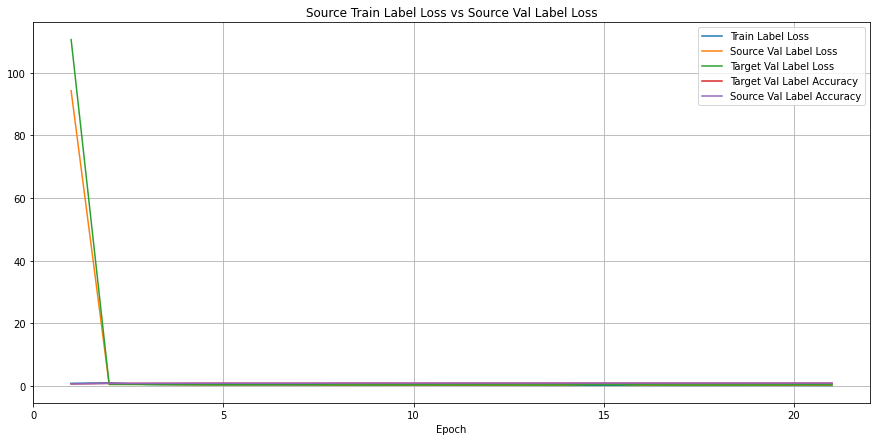

In [25]:
ax = get_loss_curve(experiment)
plt.show()

<AxesSubplot:title={'center':'Results'}>

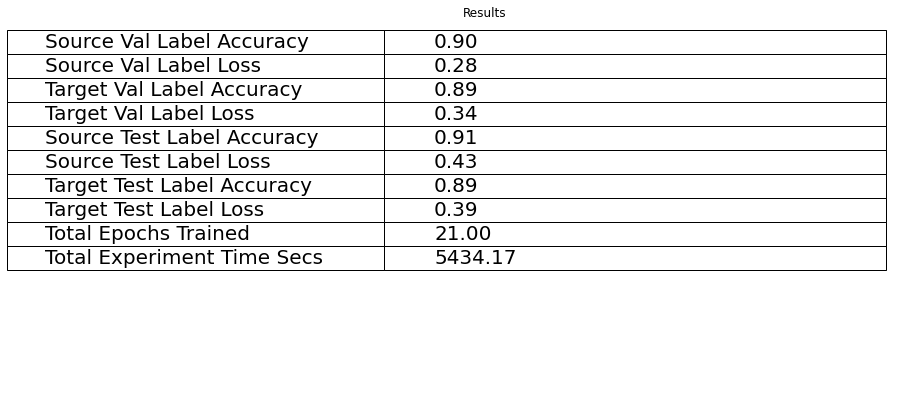

In [26]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Validation Accuracy'}, xlabel='domain'>

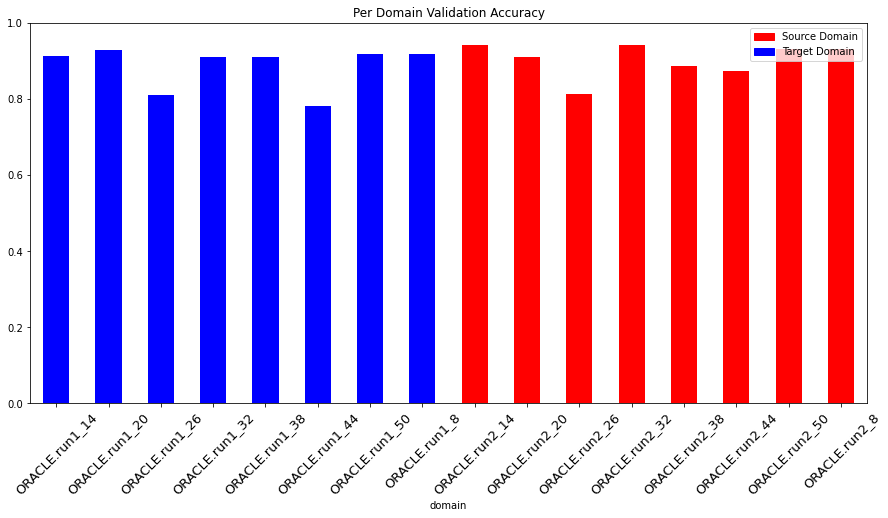

In [27]:
get_domain_accuracies(experiment)

In [28]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.9074544270833333 Target Test Label Accuracy: 0.8904296875
Source Val Label Accuracy: 0.9041015625 Target Val Label Accuracy: 0.8861653645833333


In [29]:
json.dumps(experiment)

'{"experiment_name": "tl_1v2:oracle.run1.framed-oracle.run2.framed", "parameters": {"experiment_name": "tl_1v2:oracle.run1.framed-oracle.run2.framed", "device": "cuda", "lr": 0.0001, "n_shot": 3, "n_query": 2, "train_k_factor": 3, "val_k_factor": 2, "test_k_factor": 2, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_accuracy", "x_net": [{"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}}, {"class": "Conv2d", "kargs": {"in_channels": 1, "out_channels": 256, "kernel_size": [1, 7], "bias": false, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 256}}, {"class": "Conv2d", "kargs": {"in_channels": 256, "out_channels": 80, "kernel_size": [2, 7], "bias": true, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 80}}, {"class": "Flatten", "kargs": {}}, {"class": "Linear", "kargs": {"in_features": 2048